In [1]:
%matplotlib inline

from abtem import __version__
print('current version:', __version__)

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import matplotlib.pyplot as plt

from ase.visualize import view

from abtem import *

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as c
from abtem.transfer import scherzer_defocus
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 10)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

from abtem.utils import fft_shift

from abtem.aperture import MultipleDeviatedApertures

current version: 1.0.0beta27


In [2]:
from abtem.custom import get_potential
from abtem.custom import get_gaussian_spread

In [3]:
def imshow_direct(X, *args, **kwargs): 
    return plt.imshow(X=np.flip(np.swapaxes(X,0,1),axis=0),*args, **kwargs)

# Parameters of the system

Creating potential with $50 \, \mathrm{nm}$ extent in both dimensions.

In [4]:
energy = 200e3
num = 20
ex = 0.05e-6/1e-10 # A # sample dimensions in x and y direction # pro TEM
extent = np.array([ex, ex])
gpts=np.array([2048,2048])
sampling = extent/gpts
phase_shift = 1 #rad
potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)

[0.24414062 0.24414062]


Parameters of imaging system are:

`energy` = $200$ keV (electron beam energy)

`Cs` = $1.2$ mm (spherical aberration)

`defocus` = $4.5\,\mathrm{\mu m}$ (defocus)

`Cc` = $1.61$ mm (chromatic aberration)

`reduced_brightness` = $2\times10^8 \mathrm{A\cdot m^{-2}\cdot sr^{-1}\cdot eV^{-1}} $ (reduced brightness $B_\mathrm{r}$)

`I` = 10 pA (probe current)

$d_{50}$ = 2.4 angstrom (for apertures with semiangle $\alpha = 1.5$ mrad)

$d_{50}$ = 11.8 angstrom (for apertures with semiangle $\alpha = 0.3$ mrad)

Value of $d_{50}$ was obtained from reduced brightness $B_\mathrm{r}$, aperture semiangle $\alpha$ and probe current $I$:

$d_{50}=\frac{2}{\pi}\sqrt{\frac{I}{B_\mathrm{r}\cdot \varphi^*}}\frac{1}{\alpha}$

Partial spatial coherrence is affected by $d_{50}$. In this scrpit parameter responsible for partial spatial coherrence is

`gaussian_spread` = $d_{50}/\sqrt{\ln{(256)}}/10^{-10}$.

In [5]:
#temporal coherrence
C3 = 1.2e-3/1e-10 #In Angstrom
Cc = 1.61e-3/1e-10 # In Angstrom
focal_spread=Cc*(0.6/energy)
#spatial coherrence parameters
reduced_brightness=2e8 
I=10e-12 

In [6]:
high_defocus = 4.5e-6/1e-10

# Two beams aperture

In [7]:
center=1
each_aperture_angle=0.3 # 0.3  a 1.5

max_semiangle=center+each_aperture_angle
potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)
aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angle,x_0=[0,0],y_0=[-center,center])
gaussian_spread=get_gaussian_spread(alpha=each_aperture_angle,energy=energy,reduced_brightness=reduced_brightness,I=I)
probe = Probe(aperture=aperture,energy=energy, defocus=high_defocus, semiangle_cutoff=max_semiangle, rolloff=0.1, Cs=C3, focal_spread=focal_spread, gaussian_spread=gaussian_spread)
probe.grid.match(potential)
#probe.ctf.show()

[0.24414062 0.24414062]


Aperture function

Text(0.5, 0, 'alpha_x [mrad]')

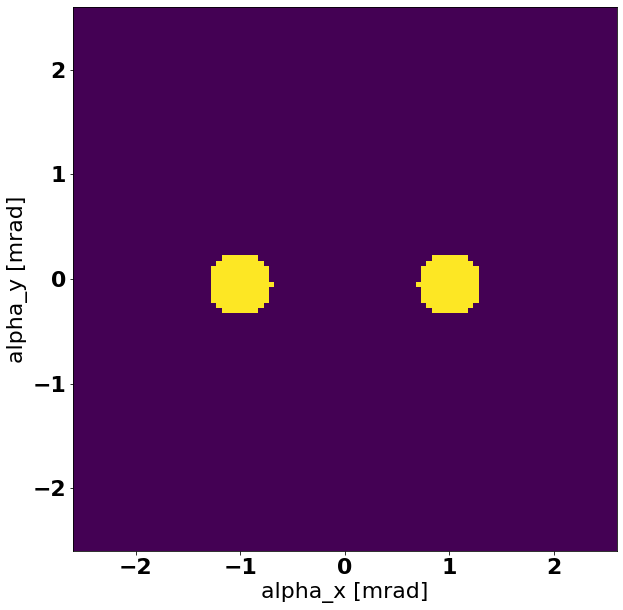

In [8]:
#%matplotlib qt
alpha_x, alpha_y = probe.get_spatial_frequencies()
alpha, phi = probe.get_scattering_angles()
alpha_x= alpha_x*probe.wavelength;alpha_y = alpha_y*probe.wavelength
ap_extent=np.array((np.min(alpha_x),np.max(alpha_x),np.min(alpha_y),np.max(alpha_y)))*1e3 # extent will be [mrad]
plt.imshow(np.swapaxes(np.abs(fft_shift(probe.ctf.evaluate_aperture(alpha,phi),np.array(gpts//2))) ,0,1) ,extent=ap_extent)
plt.xlim(-max_semiangle*2,max_semiangle*2)
plt.ylim(-max_semiangle*2,max_semiangle*2)
plt.ylabel("alpha_y [mrad]")
plt.xlabel("alpha_x [mrad]")

Probe before hitting the sample 

(83.33333333333331, 416.66666666666663)

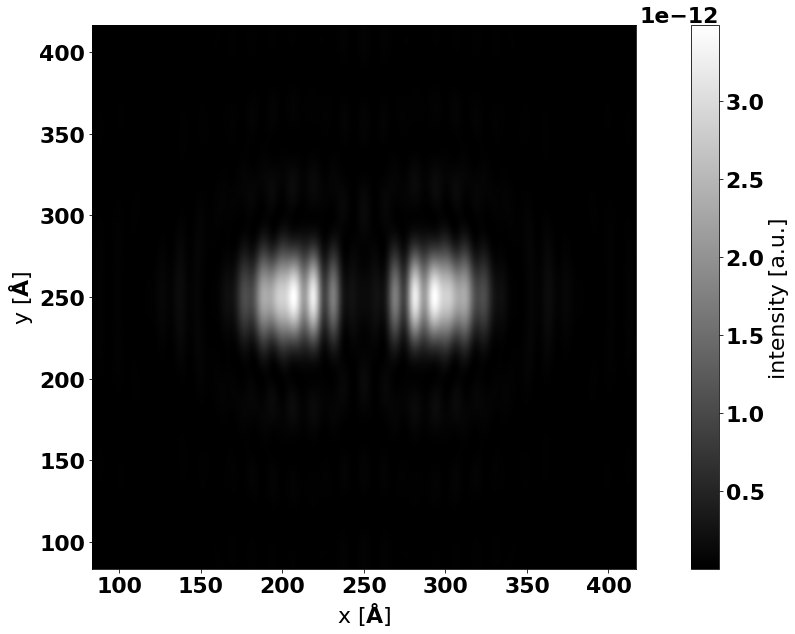

In [9]:
#%matplotlib qt
#probe.show()
imshow_direct(probe.build().intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=3
cent=extent[0]/2
zoom=extent[0]/zoom
plt.xlim(cent-zoom,cent+zoom)
plt.ylim(cent-zoom,cent+zoom)

Running multislice simulation

In [10]:
center_pos = sampling*gpts//2
measurement = probe.multislice(positions=center_pos, potential=potential)

Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

Wave after passing thorugh the sample

In [11]:
imshow_direct(measurement.intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=3
cent=extent[0]/2
zoom=extent[0]/zoom
plt.xlim(cent-zoom,cent+zoom)
plt.ylim(cent-zoom,cent+zoom)

(83.33333333333331, 416.66666666666663)

Propagating wave into crossover

In [12]:
#inspired by https://github.com/jacobjma/abTEM/issues/56
from abtem.waves import FresnelPropagator
propagator = FresnelPropagator()
delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
print(delta_z)
probe_propagated = propagator.propagate(measurement, dz=high_defocus-delta_z, in_place=False) # propagate 50 Å

11.999995999999731


Wave at crossover

In [13]:
#%matplotlib inline
#probe_propagated.show()
imshow_direct(probe_propagated.intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=10
cent=extent[0]/2
zoom=extent[0]/zoom
plt.xlim(cent-zoom,cent+zoom)
plt.ylim(cent-zoom,cent+zoom)

(199.99999999999997, 299.99999999999994)

Applying TEM's contrast transfer function which is at optimal Scherzer condition

In [14]:
1/20*probe.wavelength

semiangle_cutoff = 10.5
defocus_0 = scherzer_defocus(Cs=C3,energy=energy)
ctf = CTF(
    energy = energy,
    semiangle_cutoff = semiangle_cutoff, # mrad
    focal_spread = focal_spread, # Å
    defocus = defocus_0, # Å
    Cs = C3, # Å
    rolloff=0.01
)

image_wave_confocal = probe_propagated.apply_ctf(ctf)

Showing resulting TEM image

In [15]:
#%matplotlib inline
#probe_propagated.show()
imshow_direct(image_wave_confocal.intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("y [$\mathrm{\AA}$]")
zoom=10
cent=extent[0]/2
plt.xlim(cent-extent[0]/zoom,cent+extent[0]/zoom)
plt.ylim(cent-extent[1]/zoom,cent+extent[1]/zoom)

(199.99999999999997, 299.99999999999994)

Cut along x direction of TEM image

In [16]:
y=image_wave_confocal.intensity().array[0][:,gpts[0]//2]
x=np.linspace(0,extent[1],len(y))
plt.plot(x,y)
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("intensity [a.u.]")
zoom=10
plt.xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)

(199.99999999999997, 299.99999999999994)

In the following there will be tested influence of three parameters on the resulting interference pattern:
* `radius` - semiangle of the apertures
* `center` - semiangle between centers of the apertures
* `defocus` - defocus

# Two beams aperture: width of diffraction pattern (larger radius of aperture smaler diffraction pattern) 

In [17]:
zoom = 10
lines = 5
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

centers = np.array([2,2])

each_aperture_angles = np.array([1.5,0.3])

for idx,_ in enumerate(centers):
    center=centers[idx]
    max_semiangle=center+each_aperture_angles[idx]
    potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)
    gaussian_spread=get_gaussian_spread(alpha=each_aperture_angles[idx],energy=energy,reduced_brightness=reduced_brightness,I=I)
    aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angles[idx],x_0=[0,0],y_0=[-center,center])
    probe = Probe(aperture=aperture,energy=energy, defocus=high_defocus, semiangle_cutoff=max_semiangle, rolloff=0.1, Cs=C3, focal_spread=focal_spread, gaussian_spread=gaussian_spread);probe.grid.match(potential)
    #probe.ctf.show()

    center_pos = sampling*gpts//2
    measurement = probe.multislice(positions=center_pos, potential=potential)


    propagator = FresnelPropagator()

    delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
    delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
    print(delta_z)
    probe_propagated = propagator.propagate(measurement, dz=high_defocus-delta_z, in_place=False) # propagate 50 Å
    image_wave_confocal = probe_propagated.apply_ctf(ctf)
    y=image_wave_confocal.intensity().array[0][:,gpts[0]//2]
    x=np.linspace(0,extent[1],len(y))
    #plt.plot(x,y,label=r"phase shift = ${:.2f}\pi\,$rad; center ${:.1f}$ mrad; radius ${:.1f}$ mrad".format(phase_shift/np.pi,center,each_aperture_angles[idx]))
    plt.plot(x,y,label=r"center = ${:.1f}$ mrad; radius = ${:.1f}$ mrad".format(center,each_aperture_angles[idx]))
    
plt.legend()
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("intensity [a.u.]")
plt.xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)



[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

47.999935999982924
[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

47.999935999982924


(199.99999999999997, 299.99999999999994)

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

47.999935999982924


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

47.999935999982924


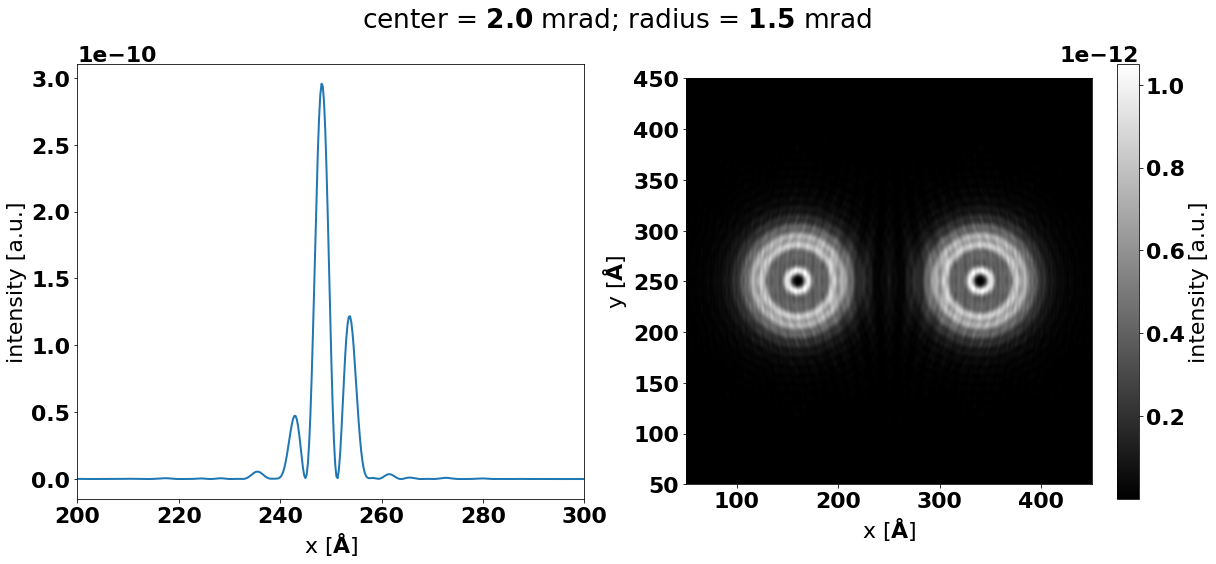

In [18]:
lines = 5
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

centers = np.array([2,2])

each_aperture_angles = np.array([1.5,0.3])

potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)

for idx,_ in enumerate(centers):
    center=centers[idx]
    max_semiangle=center+each_aperture_angles[idx]
    aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angles[idx],x_0=[0,0],y_0=[-center,center])
    gaussian_spread=get_gaussian_spread(alpha=each_aperture_angles[idx],energy=energy,reduced_brightness=reduced_brightness,I=I)
    probe = Probe(aperture=aperture,energy=energy, defocus=high_defocus, semiangle_cutoff=max_semiangle, rolloff=0.1, Cs=C3, focal_spread=focal_spread, gaussian_spread=gaussian_spread);probe.grid.match(potential)
    #probe.ctf.show()

    center_pos = sampling*gpts//2
    measurement = probe.multislice(positions=center_pos, potential=potential)


    propagator = FresnelPropagator()

    delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
    delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
    print(delta_z)
    probe_propagated = propagator.propagate(measurement, dz=high_defocus-delta_z, in_place=False) # propagate 50 Å
    image_wave_confocal = probe_propagated.apply_ctf(ctf)
    y=image_wave_confocal.intensity().array[0][:,gpts[0]//2]
    x=np.linspace(0,extent[1],len(y))
    
    fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(20,8))
    fig.suptitle(r"center = ${:.1f}$ mrad; radius = ${:.1f}$ mrad".format(center,each_aperture_angles[idx]))
    
    ax1.plot(x,y,label=r"center = ${:.1f}$ mrad; radius = ${:.1f}$ mrad".format(center,each_aperture_angles[idx]))    
    ax1.set_xlabel("x [$\mathrm{\AA}$]")
    ax1.set_ylabel("intensity [a.u.]")
    zoom = 10
    ax1.set_xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)

    imshow_direct(probe.build().intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
    ax2.set_xlabel("x [$\mathrm{\AA}$]")
    ax2.set_ylabel("y [$\mathrm{\AA}$]")
    zoom_d=2.5
    cent=extent[0]/2
    ax2.set_xlim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)
    ax2.set_ylim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)

# Two beams withl larger aperture: interference fringe peak width (closer apertures give wider peaks)

## aperture semiangle - 1.5 mrad
## defocus - 4.5 mrad

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

26.999979749996957


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

47.999935999982924


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

74.9998437499349


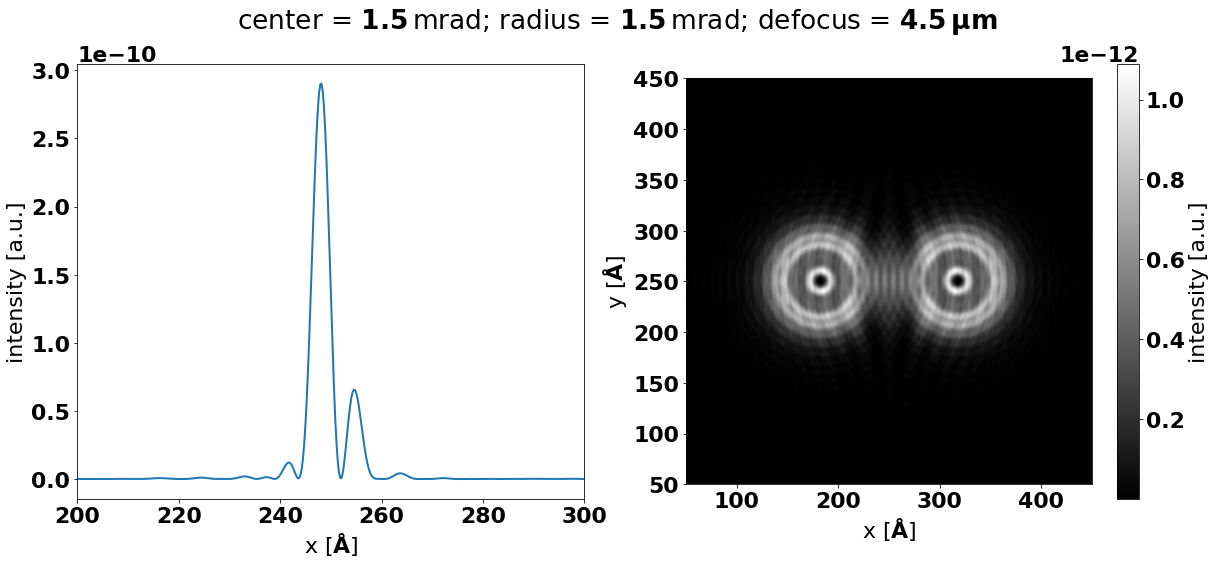

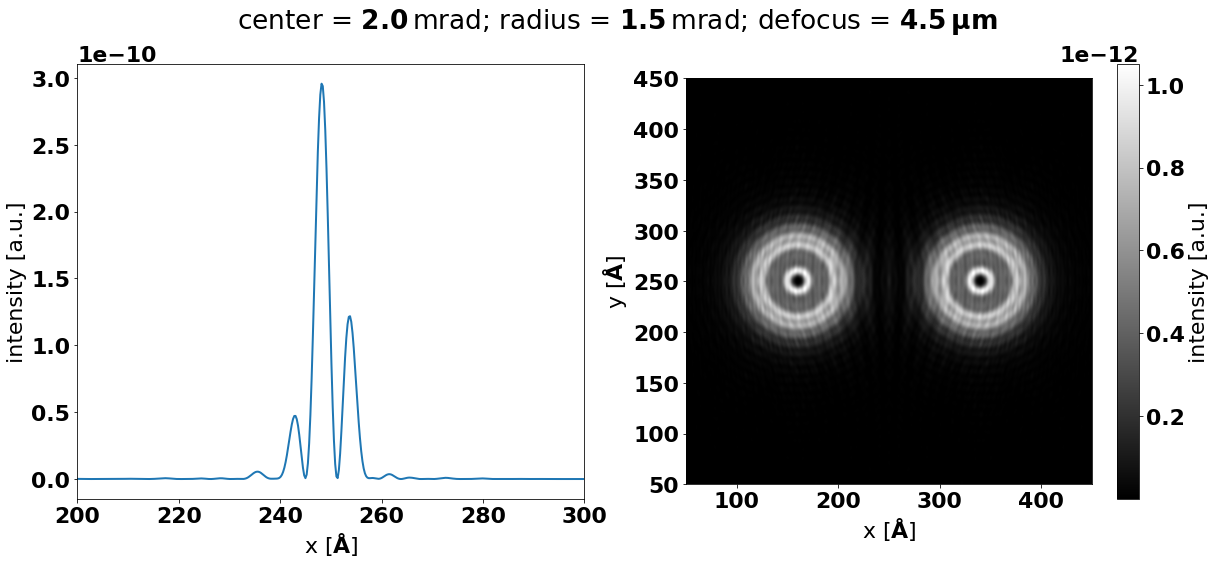

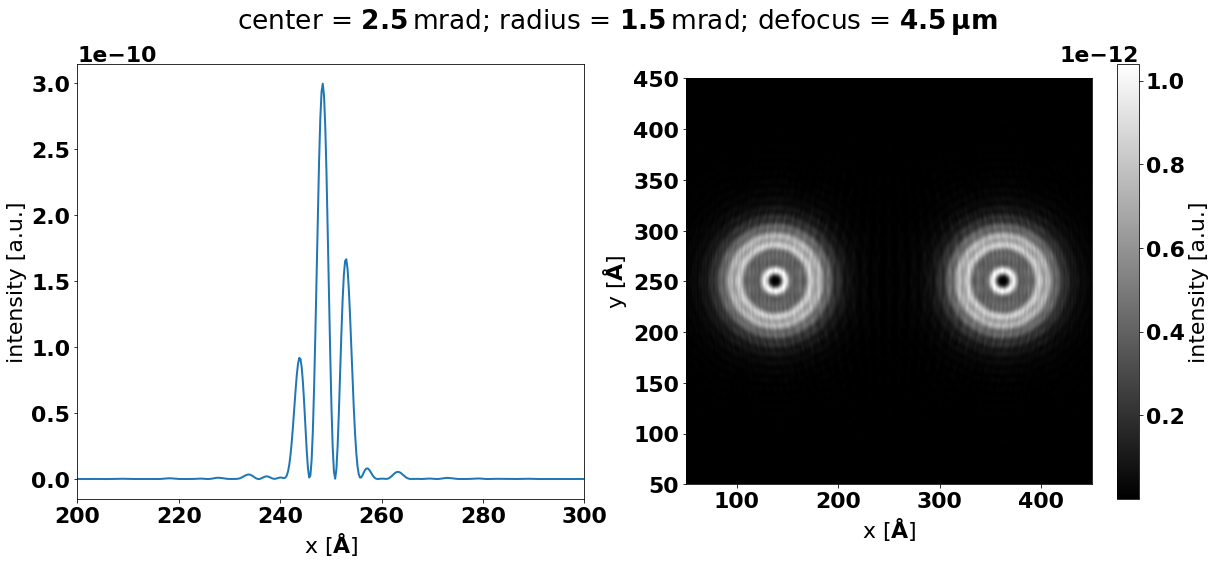

In [19]:
lines = 5
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

centers = np.array([1.5,2.0,2.5])

each_aperture_angles = np.array([1.5,1.5,1.5])

potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)

for idx,_ in enumerate(centers):
    center=centers[idx]
    max_semiangle=center+each_aperture_angles[idx]
    aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angles[idx],x_0=[0,0],y_0=[-center,center])
    gaussian_spread=get_gaussian_spread(alpha=each_aperture_angles[idx],energy=energy,reduced_brightness=reduced_brightness,I=I)
    probe = Probe(aperture=aperture,energy=energy, defocus=high_defocus, semiangle_cutoff=max_semiangle, rolloff=0.1, Cs=C3, focal_spread=focal_spread, gaussian_spread=gaussian_spread);probe.grid.match(potential)
    #probe.ctf.show()

    center_pos = sampling*gpts//2
    measurement = probe.multislice(positions=center_pos, potential=potential)


    propagator = FresnelPropagator()

    delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
    delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
    print(delta_z)
    probe_propagated = propagator.propagate(measurement, dz=high_defocus-delta_z, in_place=False) # propagate 50 Å
    image_wave_confocal = probe_propagated.apply_ctf(ctf)
    y=image_wave_confocal.intensity().array[0][:,gpts[0]//2]
    x=np.linspace(0,extent[1],len(y))
    
    fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(20,8))
    fig.suptitle(r"center = ${:.1f}\,$mrad; radius = ${:.1f}\,$mrad; defocus = ${:.1f}\,\mathrm{{\mu m}}$".format(center,each_aperture_angles[idx],high_defocus*1e-10/1e-6))

    
    ax1.plot(x,y,label=r"center = ${:.1f}$ mrad; radius = ${:.1f}$ mrad".format(center,each_aperture_angles[idx]))    
    ax1.set_xlabel("x [$\mathrm{\AA}$]")
    ax1.set_ylabel("intensity [a.u.]")
    zoom = 10
    ax1.set_xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)

    imshow_direct(probe.build().intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
    ax2.set_xlabel("x [$\mathrm{\AA}$]")
    ax2.set_ylabel("y [$\mathrm{\AA}$]")
    zoom_d=2.5
    cent=extent[0]/2
    ax2.set_xlim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)
    ax2.set_ylim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)

# Two beams with larger aperture: distance between both beams (is proportional to defocus value)

## aperture semiangle - 1.5 mrad
##  angle between centers of apertures - 4 mrad

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

47.999935999982924


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

47.999935999982924


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

47.999935999982924


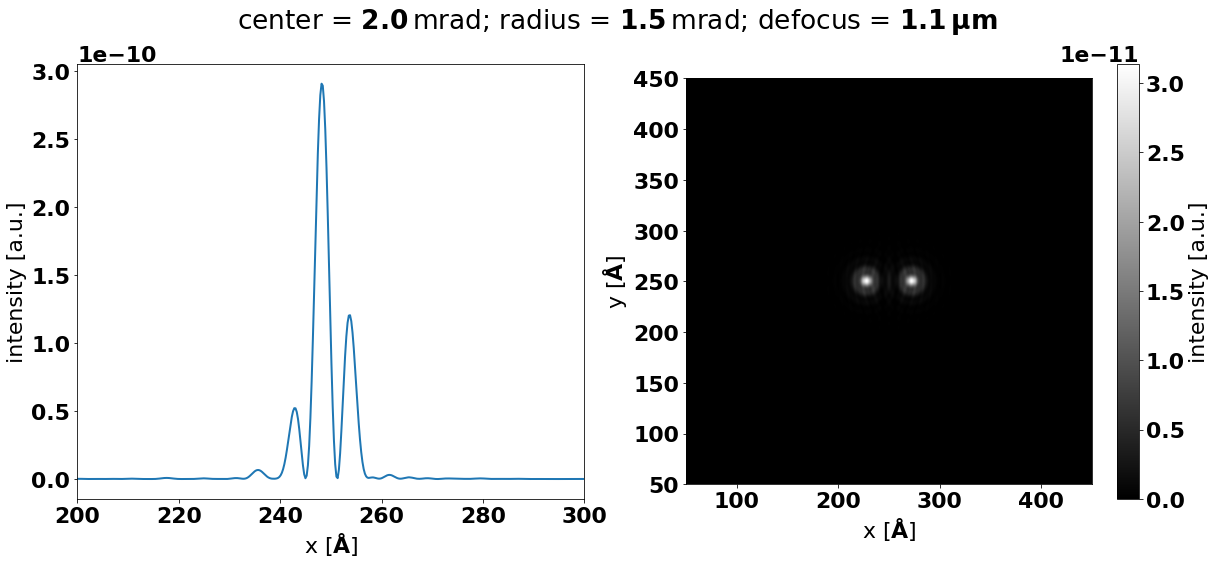

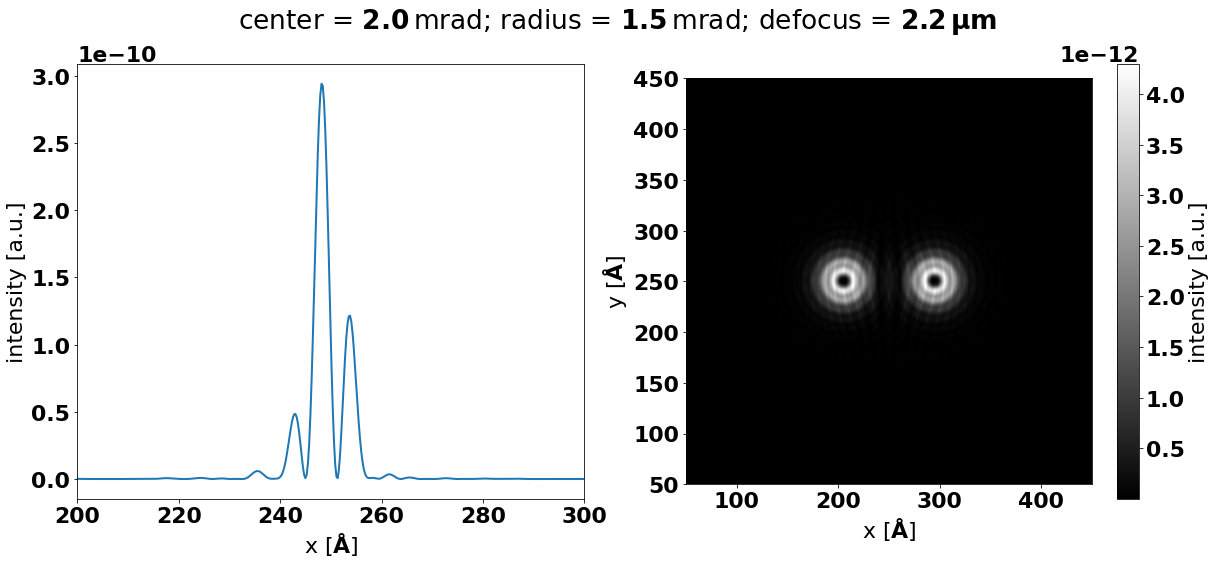

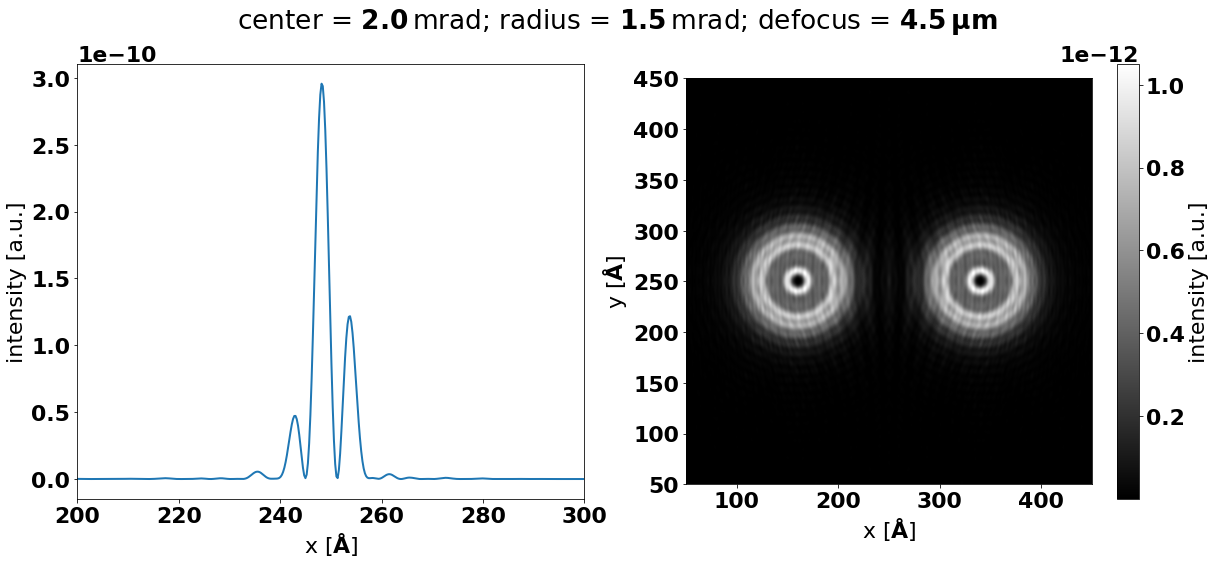

In [20]:
lines = 5
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

centers = np.array([2.0,2.0,2.0])

each_aperture_angles = np.array([1.5,1.5,1.5])

high_defocuss = np.array([high_defocus/4,high_defocus/2,high_defocus])

potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)

for idx,_ in enumerate(centers):
    center=centers[idx]
    max_semiangle=center+each_aperture_angles[idx]
    aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angles[idx],x_0=[0,0],y_0=[-center,center])
    gaussian_spread=get_gaussian_spread(alpha=each_aperture_angles[idx],energy=energy,reduced_brightness=reduced_brightness,I=I)
    probe = Probe(aperture=aperture,energy=energy, defocus=high_defocuss[idx], semiangle_cutoff=max_semiangle, rolloff=0.1, Cs=C3, focal_spread=focal_spread, gaussian_spread=gaussian_spread);probe.grid.match(potential)
    #probe.ctf.show()

    center_pos = sampling*gpts//2
    measurement = probe.multislice(positions=center_pos, potential=potential)


    propagator = FresnelPropagator()

    delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
    delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
    print(delta_z)
    probe_propagated = propagator.propagate(measurement, dz=high_defocuss[idx]-delta_z, in_place=False) # propagate 50 Å
    image_wave_confocal = probe_propagated.apply_ctf(ctf)
    y=image_wave_confocal.intensity().array[0][:,gpts[0]//2]
    x=np.linspace(0,extent[1],len(y))
    
    fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(20,8))
    fig.suptitle(r"center = ${:.1f}\,$mrad; radius = ${:.1f}\,$mrad; defocus = ${:.1f}\,\mathrm{{\mu m}}$".format(center,each_aperture_angles[idx],high_defocuss[idx]*1e-10/1e-6))
    
    ax1.plot(x,y,label=r"center = ${:.1f}\,$mrad; radius = ${:.1f}\,$mrad".format(center,each_aperture_angles[idx]))    
    ax1.set_xlabel("x [$\mathrm{\AA}$]")
    ax1.set_ylabel("intensity [a.u.]")
    zoom = 10
    ax1.set_xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)

    imshow_direct(probe.build().intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
    ax2.set_xlabel("x [$\mathrm{\AA}$]")
    ax2.set_ylabel("y [$\mathrm{\AA}$]")
    zoom_d=2.5
    cent=extent[0]/2
    ax2.set_xlim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)
    ax2.set_ylim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)

# Two beams with smaller aperture: interference fringe peak width (closer apertures give wider peaks)

## aperture semiangle - 0.3 mrad 
## defocus - 4.5 $\mathrm{\mu m}$

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

5.8799990395999675


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

7.67999836159993


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

9.719997375599858


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

14.519994143599526


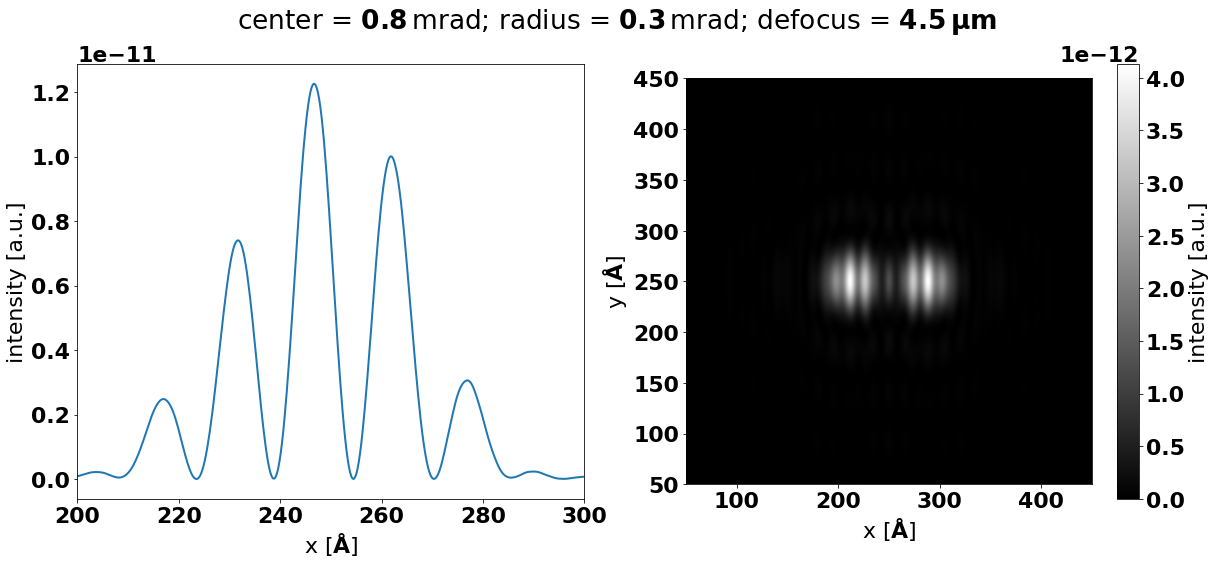

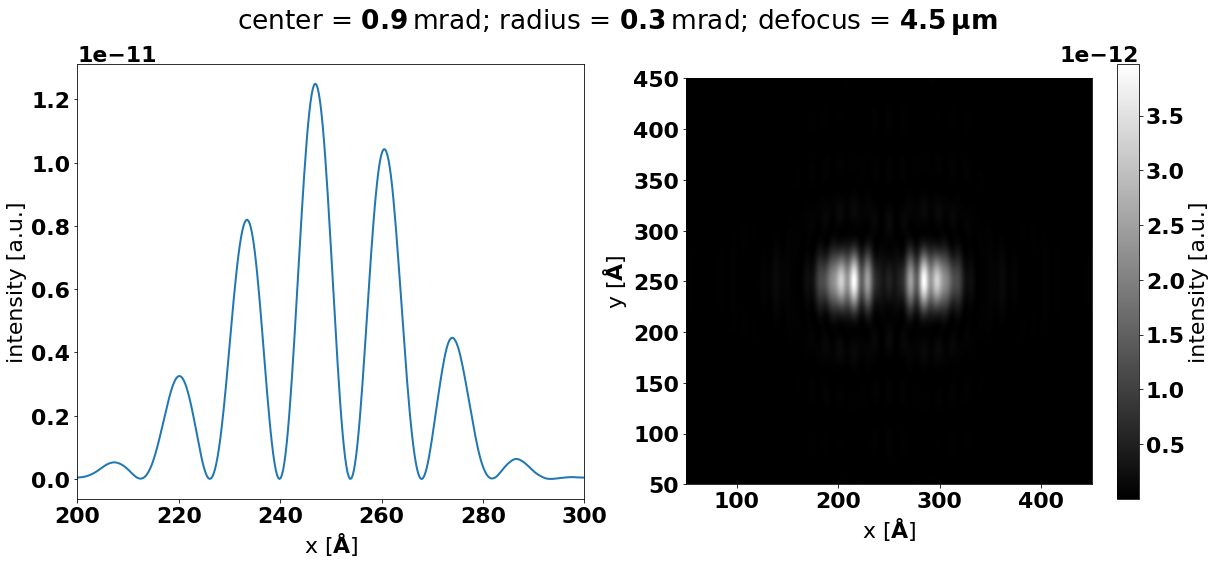

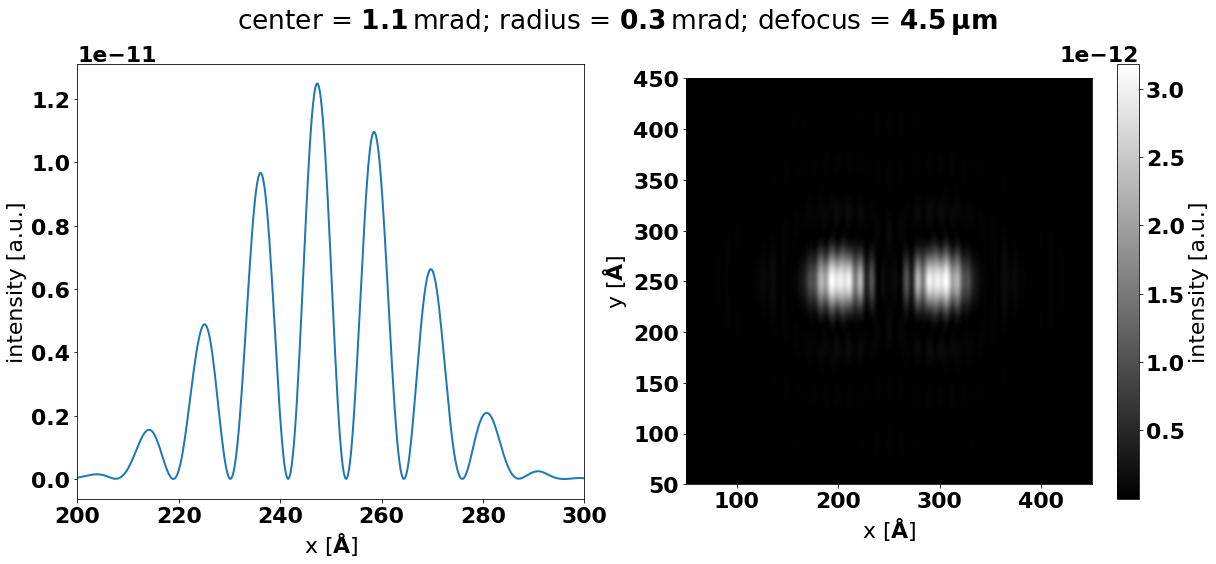

In [21]:
lines = 5
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

centers = np.linspace(0.7,1.1,5)

each_aperture_angles = np.ones(len(centers))*0.3

potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)

for idx,_ in enumerate(centers):
    center=centers[idx]
    max_semiangle=center+each_aperture_angles[idx]
    aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angles[idx],x_0=[0,0],y_0=[-center,center])
    gaussian_spread=get_gaussian_spread(alpha=each_aperture_angles[idx],energy=energy,reduced_brightness=reduced_brightness,I=I)
    probe = Probe(aperture=aperture,energy=energy, defocus=high_defocus, semiangle_cutoff=max_semiangle, rolloff=0.1, Cs=C3, focal_spread=focal_spread, gaussian_spread=gaussian_spread);probe.grid.match(potential)
    #probe.ctf.show()

    center_pos = sampling*gpts//2
    measurement = probe.multislice(positions=center_pos, potential=potential)


    propagator = FresnelPropagator()

    delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
    delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
    print(delta_z)
    probe_propagated = propagator.propagate(measurement, dz=high_defocus-delta_z, in_place=False) # propagate 50 Å
    image_wave_confocal = probe_propagated.apply_ctf(ctf)
    y=image_wave_confocal.intensity().array[0][:,gpts[0]//2]
    x=np.linspace(0,extent[1],len(y))
    
    fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(20,8))
    fig.suptitle(r"center = ${:.1f}\,$mrad; radius = ${:.1f}\,$mrad; defocus = ${:.1f}\,\mathrm{{\mu m}}$".format(center,each_aperture_angles[idx],high_defocus*1e-10/1e-6))

    
    ax1.plot(x,y,label=r"center = ${:.1f}$ mrad; radius = ${:.1f}$ mrad".format(center,each_aperture_angles[idx]))    
    ax1.set_xlabel("x [$\mathrm{\AA}$]")
    ax1.set_ylabel("intensity [a.u.]")
    zoom = 10
    ax1.set_xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)

    imshow_direct(probe.build().intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
    ax2.set_xlabel("x [$\mathrm{\AA}$]")
    ax2.set_ylabel("y [$\mathrm{\AA}$]")
    zoom_d=2.5
    cent=extent[0]/2
    ax2.set_xlim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)
    ax2.set_ylim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)

# Two beams with smaller aperture: distance between both beams (is proportional to defocus value)

## aperture semiangle - 0.3 mrad 
## semiangle between centers of apertures - 1 mrad

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731


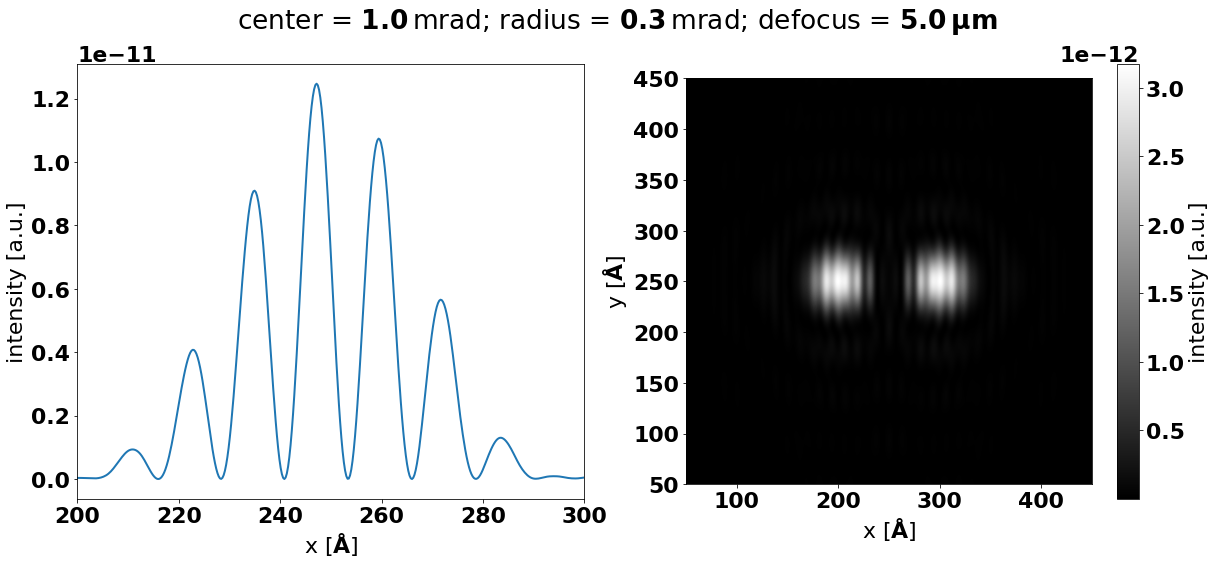

In [22]:
lines = 5
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]

centers = np.array([1.0,1.0,1.0])

each_aperture_angles = np.array([0.3,0.3,0.3])

high_defocuss = np.array([3/5,4/5,1])*5e-6/1e-10

potential = get_potential(phase_shift=phase_shift,extent=extent,energy=energy,gpts=gpts,num=num)

for idx,_ in enumerate(centers):
    center=centers[idx]
    max_semiangle=center+each_aperture_angles[idx]
    aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angles[idx],x_0=[0,0],y_0=[-center,center])
    gaussian_spread=get_gaussian_spread(alpha=each_aperture_angles[idx],energy=energy,reduced_brightness=reduced_brightness,I=I)
    probe = Probe(aperture=aperture,energy=energy, defocus=high_defocuss[idx], semiangle_cutoff=max_semiangle, rolloff=0.1, Cs=C3, focal_spread=focal_spread, gaussian_spread=gaussian_spread);probe.grid.match(potential)
    #probe.ctf.show()

    center_pos = sampling*gpts//2
    measurement = probe.multislice(positions=center_pos, potential=potential)


    propagator = FresnelPropagator()

    delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
    delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
    print(delta_z)
    probe_propagated = propagator.propagate(measurement, dz=high_defocuss[idx]-delta_z, in_place=False) # propagate 50 Å
    image_wave_confocal = probe_propagated.apply_ctf(ctf)
    y=image_wave_confocal.intensity().array[0][:,gpts[0]//2]
    x=np.linspace(0,extent[1],len(y))
    
    fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(20,8))
    fig.suptitle(r"center = ${:.1f}\,$mrad; radius = ${:.1f}\,$mrad; defocus = ${:.1f}\,\mathrm{{\mu m}}$".format(center,each_aperture_angles[idx],high_defocuss[idx]*1e-10/1e-6))
    
    ax1.plot(x,y,label=r"center = ${:.1f}\,$mrad; radius = ${:.1f}\,$mrad".format(center,each_aperture_angles[idx]))    
    ax1.set_xlabel("x [$\mathrm{\AA}$]")
    ax1.set_ylabel("intensity [a.u.]")
    zoom = 10
    ax1.set_xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)

    imshow_direct(probe.build().intensity().array[0],extent=(0,extent[0],0,extent[1]),cmap="gray");plt.colorbar(label="intensity [a.u.]")
    ax2.set_xlabel("x [$\mathrm{\AA}$]")
    ax2.set_ylabel("y [$\mathrm{\AA}$]")
    zoom_d=2.5
    cent=extent[0]/2
    ax2.set_xlim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)
    ax2.set_ylim(cent-extent[0]/zoom_d,cent+extent[0]/zoom_d)

# Summary

In order to easily measure the interference pattern we are forced to place apertures as close as possible. Then individual peaks in the interference pattern will be then the widest. 

If we also choose apertures with a smaller semiangle (0.3 mrad), then we will be able to get even closer with the apertures. Also the smaller diameter will ensure that the whole interference pattern will be wider and more interference fringes will be visible. 

If we restrain ourselves to work with defocus values under 5.0 $\mu m$, then the highest defocus value would be advised so that the beams would be separeted sufficiently before they hit the sample. To have some headroom we may choose defocus to 4.5 $\mu m$ and the beams should still be far away from each other. 

With defocus set to 4.5 $\mu m$ the best semiangle between apertures would seem to be above $0.8$ mrad. So that semiangle angle between apertures of 1 mrad should suffice. 

# Dependence on phase shift 

## defocus - 4.5 $\mathrm{\mu m}$ 
## aperture semiangle - 0.3 mrad 
## semiangle between centers of apertures - 1 mrad

[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731
[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731
[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731
[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731
[0.24414062 0.24414062]


Multislice:   0%|          | 0/20 [00:00<?, ?it/s]

11.999995999999731


(199.99999999999997, 299.99999999999994)

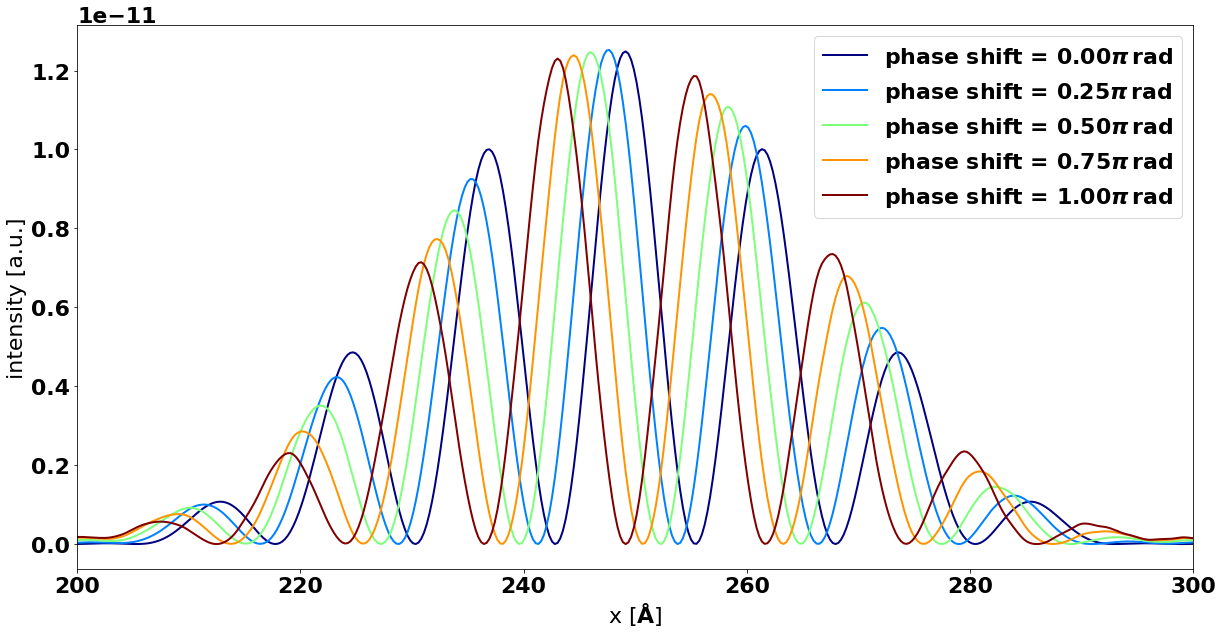

In [23]:
lines = 5
colors = [ matplotlib.cm.jet(x) for x in np.linspace(0, 1, lines) ]



phase_shifts=np.linspace(0,np.pi,lines)
each_aperture_angles = np.ones(len(phase_shifts))*0.3
centers = np.ones(len(phase_shifts))*1.0
high_defocuss = np.ones(len(phase_shifts))*4.5e-6/1e-10

for idx,_ in enumerate(phase_shifts):
    potential = get_potential(phase_shift=phase_shifts[idx],extent=extent,energy=energy,gpts=gpts,num=num)
    center=centers[idx]
    max_semiangle=center+each_aperture_angles[idx]
    aperture = MultipleDeviatedApertures(aperture_angle=each_aperture_angles[idx],x_0=[0,0],y_0=[-center,center])
    gaussian_spread=get_gaussian_spread(alpha=each_aperture_angles[idx],energy=energy,reduced_brightness=reduced_brightness,I=I)
    probe = Probe(aperture=aperture,energy=energy, defocus=high_defocuss[idx], semiangle_cutoff=max_semiangle, rolloff=0.1, Cs=C3, focal_spread=focal_spread, gaussian_spread=gaussian_spread);probe.grid.match(potential)
    #probe.ctf.show()

    center_pos = sampling*gpts//2
    measurement = probe.multislice(positions=center_pos, potential=potential)


    propagator = FresnelPropagator()

    delta_x = C3*(center*1e-3)**3 # probe deviation thanks to C3 in lateral side
    delta_z = delta_x/np.tan(center*1e-3) #probe in beam direction thanks to C3
    print(delta_z)
    probe_propagated = propagator.propagate(measurement, dz=high_defocuss[idx]-delta_z, in_place=False) # propagate 50 Å
    y=probe_propagated.intensity().array[0][:,gpts[0]//2]
    x=np.linspace(0,extent[1],len(y))
    plt.plot(x,y,label=r"phase shift = ${:.2f}\pi\,$rad".format(phase_shifts[idx]/np.pi),color=colors[idx])

    
plt.legend()
plt.xlabel("x [$\mathrm{\AA}$]")
plt.ylabel("intensity [a.u.]")
zoom=10
plt.xlim(extent[1]/2-extent[1]/zoom,extent[1]/2+extent[1]/zoom)

